
# Step 1: Install Dependencies (if needed in Google Colab)



In [ ]:
import os
!https://github.com/Maria-Elisa-M/BW_prediction_keypoint.git
os.chdir('BW_prediction_keypoint')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ultralytics pandas matplotlib numpy opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.8/921.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# Step 2: Import Required Libraries

In [3]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Step 3: Define Paths

In [ ]:
main_dir = '/depth'
# Define paths for images and YOLO model
image_path = os.path.join(main_dir, 'Images','4580_20220815_094641_depth_frame_0.png')  # Update with your file path
model_path = os.path.join(main_dir, 'keypoint/stream3/train3/weights/best.pt')

# Step 4: Load YOLO Model

In [10]:
model = YOLO(model_path)

# Step 5: Run Inference on Image

In [11]:
results = model(image_path)[0]  # Get first result

# Load image using OpenCV
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


image 1/1 /content/drive/MyDrive/guilherme/depth/Images/4580_20220815_094641_depth_frame_0.png: 384x672 1 cow, 457.0ms
Speed: 18.7ms preprocess, 457.0ms inference, 37.8ms postprocess per image at shape (1, 3, 384, 672)


# Step 6: Extract Keypoints & Plot on Image

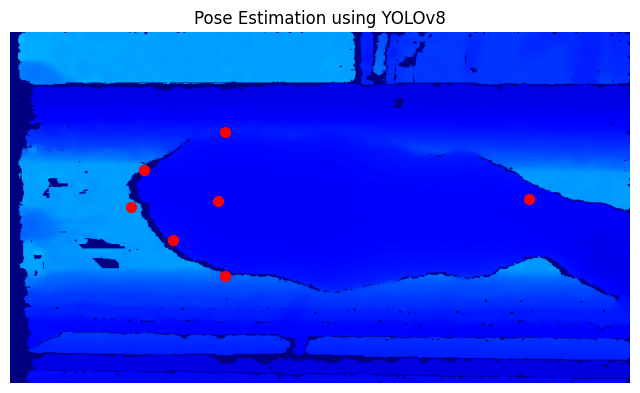

In [17]:
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")

keypoints_list = []
if results.keypoints is not None:
    for pose in results.keypoints.xy.cpu().numpy():
        keypoints_list.append(pose[:, :2])  # Extract (x, y) coordinates
        for kp in pose:
            x, y = kp[:2]
            plt.scatter(x, y, c='red', s=50)  # Plot keypoints

plt.title("Pose Estimation using YOLOv8")
plt.show()

# Step 7: Compute Euclidean Distances & Store in DataFrame

In [18]:
keypoint_indices = list(range(7))  # Select keypoints 0-6
columns = ['image_name'] + [f"{i}_x" for i in keypoint_indices] + [f"{i}_y" for i in keypoint_indices]
columns += [f"dist_{i}_{j}" for i, j in combinations(keypoint_indices, 2)]
df = pd.DataFrame(columns=columns)

keypoints = []
if results.keypoints is not None:
    for pose in results.keypoints.xy.cpu().numpy():
        row = [os.path.basename(image_path)]
        keypoints = []

        for i in keypoint_indices:
            if i < len(pose):
                x, y = int(pose[i][0]), int(pose[i][1])
            else:
                x, y = np.nan, np.nan
            keypoints.append((x, y))
            row.extend([x, y])

        # Compute Distances
        distance_dict = {}
        for i, j in combinations(keypoint_indices, 2):
            if np.nan not in (keypoints[i] + keypoints[j]):
                dist = np.sqrt((keypoints[i][0] - keypoints[j][0])**2 +
                               (keypoints[i][1] - keypoints[j][1])**2)
            else:
                dist = np.nan
            row.append(dist)
            distance_dict[f"dist_{i}_{j}"] = dist

        df.loc[len(df)] = row

# Step 8: Display DataFrame of Keypoints & Distances

In [19]:
print("Extracted Keypoints and Distances:")
print(df)


Extracted Keypoints and Distances:
                               image_name  0_x  1_x  2_x  3_x  4_x  5_x  6_x  \
0  4580_20220815_094641_depth_frame_0.png  294  332  294  136  222  284  182   

   0_y  1_y  ...  dist_2_3   dist_2_4   dist_2_5    dist_2_6   dist_3_4  \
0  188  164  ...     104.0  73.409809  81.467785  490.209139  54.083269   

     dist_3_5    dist_3_6    dist_4_5    dist_4_6    dist_5_6  
0  109.384642  528.515846  119.339851  545.110998  426.004695  

[1 rows x 36 columns]


# Step 9: Plot Keypoint Trajectories on Image

(-0.5, 847.5, 479.5, -0.5)

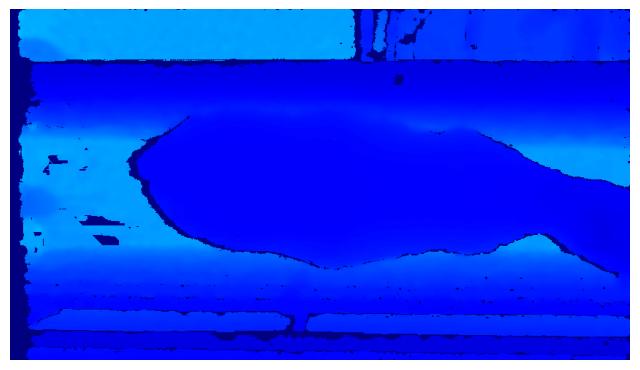

In [20]:
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")

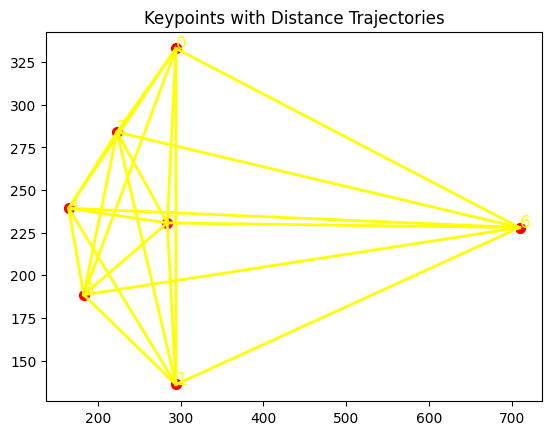

In [21]:
# Draw keypoints
if keypoints_list:
    keypoints_array = np.array(keypoints_list[0])
    for i, (x, y) in enumerate(keypoints_array):
        plt.scatter(x, y, c='red', s=50)
        plt.text(x, y, f"{i}", fontsize=12, color="yellow")

    # Draw connecting lines (trajectories)
    for i, j in combinations(keypoint_indices, 2):
        if not np.isnan(keypoints_array[i]).any() and not np.isnan(keypoints_array[j]).any():
            plt.plot([keypoints_array[i][0], keypoints_array[j][0]],
                     [keypoints_array[i][1], keypoints_array[j][1]], 'yellow', linewidth=2)

plt.title("Keypoints with Distance Trajectories")
plt.show()